# Stacking 
* LR with K fold CV 
* 27.22

.

`stacking 방법`
1. simple linear regression : 27.22
2. RFE (feature selection) : 27.22
3. lr without intercept : 27.64
4. nnls : 27.23, (절편 X : 27.61) 

In [14]:
import os
import sys
import glob
import joblib
import pickle as pkl

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


import pandas as pd 
import numpy as np


from IPython.display import display
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.max_info_columns', 500)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

In [147]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [174]:
# MAPE 
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data Prep

### model pkl load

In [29]:
cd FinalPred

/Users/jbeen/workdir/bigcontest/branch/Shopping_GG/Stacking/FinalPred


In [30]:
pkls = glob.glob('*.pickle')
pkls

['lgbm_pred0921-lgbm-bayes2.pickle',
 'lgbm_pred0921-lgbm-optuna2.pickle',
 'lgbm_pred0921-lgbm-bayes.pickle',
 'lgbm_pred0921-lgbm-bayes3.pickle']

In [53]:
final = dict()
for p in pkls : 
    with open('{}'.format(p), 'rb') as f:
        final[p.split(".")[0]] = pkl.load(f)

In [57]:
# train index
final['lgbm_pred0921-lgbm-bayes2']['val_idx']

[array([    0,     2,    13, ..., 28273, 28282, 28290]),
 array([    1,     7,    15, ..., 28295, 28299, 28300]),
 array([    3,    10,    11, ..., 28287, 28289, 28297]),
 array([    4,    36,    43, ..., 28294, 28301, 28302]),
 array([    5,     6,     8, ..., 28293, 28296, 28298])]

In [58]:
# test index 
final['lgbm_pred0921-lgbm-bayes2']['test_idx']

[Int64Index([ 8734,  7885,  2413, 12475,  4571,  9835, 35907, 14833, 10316,
             31140,
             ...
             25556, 30587,  6430, 11575, 33365, 14158, 28909, 34363, 26499,
              4615],
            dtype='int64', length=7076)]

In [203]:
# test pred 
final['lgbm_pred0921-lgbm-bayes2']['final_pred']

[array([10557563.93721553, 18074929.25387817, 23836593.06907338, ...,
        29718194.91621904, 20162063.64308697, 11676675.72850286])]

### data load

In [60]:
data_v4 = joblib.load(os.path.join('..', '7th_train_FE.pkl'))
locals().update(data_v4)

In [82]:
X = data_v4['X'] ; y = data_v4['y']
X.shape, y.shape

((35379, 402), (35379,))

In [62]:
y2 = np.log1p(y)

## Meta Test 

In [110]:
X_test = X.loc[final['lgbm_pred0921-lgbm-bayes3']['test_idx'][0]]
y_test = y.loc[final['lgbm_pred0921-lgbm-bayes3']['test_idx'][0]]

In [111]:
X_test.shape, y_test.shape

((7076, 402), (7076,))

## Meta Train 
* K fold 하면서 reindex 가 되어 버려서 이렇게 나눠 줘야 함 ㅎㅎㅎ;;

In [124]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [167]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=77)
X_train, y_train = dict(), dict() 

cv = KFold(n_splits=5, random_state=77, shuffle=True)

i = 0
for t,v in cv.split(X_train_):
    X_train['{}'.format(i+1)] = X_train_.iloc[v]
    y_train['{}'.format(i+1)] = y_train_.iloc[v]
    i+=1

In [168]:
y_train

{'1': 11068    5590000.000
 33838   18118000.000
 34271   36524000.000
 14133   12638000.000
 34735   16910000.000
             ...     
 31318   13337000.000
 25841   79167000.000
 20238   28330000.000
 11231    5154000.000
 24206   48288000.000
 Name: 취급액, Length: 5661, dtype: float64,
 '2': 35359    2345000.000
 20394    7035000.000
 34515    5496000.000
 21664   27890000.000
 23113    1651000.000
             ...     
 6146    18451000.000
 28681   19073000.000
 2993     6845000.000
 27606    3942000.000
 8270     7713000.000
 Name: 취급액, Length: 5661, dtype: float64,
 '3': 19383   32053000.000
 3711    22954000.000
 2268     6338000.000
 553      6695000.000
 28997    4239000.000
             ...     
 30514   24613000.000
 23436    8125000.000
 19752   14444000.000
 1434    46194000.000
 23378   24907000.000
 Name: 취급액, Length: 5661, dtype: float64,
 '4': 4264     4260000.000
 30359   70536000.000
 18055   35674000.000
 5253     1522000.000
 19305    3833000.000
             ...  

In [169]:
for i in range(5) : 
    print(len(final['lgbm_pred0921-lgbm-bayes2']['val_idx'][i])) # length 일치 ~!! 

5661
5661
5661
5660
5660


## Final Stacking Dataset

### train

In [170]:
# train : y_true
y_train1, y_train2, y_train3, y_train4, y_train5 = y_train['1'], y_train['2'], y_train['3'], y_train['4'], y_train['5']

In [195]:
y_train1.shape, y_train2.shape, y_train3.shape, y_train4.shape, y_train5.shape

((5661,), (5661,), (5661,), (5660,), (5660,))

In [208]:
# train : y_pred
x_train1, x_train2, x_train3, x_train4, x_train5 = [], [], [], [], []
for model in list(final.keys()) : 
    x_train1.append(final[model]['val_pred'][0])
    x_train2.append(final[model]['val_pred'][1])
    x_train3.append(final[model]['val_pred'][2])
    x_train4.append(final[model]['val_pred'][3])
    x_train5.append(final[model]['val_pred'][4])

In [209]:
X_train1 = pd.DataFrame(np.array(x_train1).T)
X_train2 = pd.DataFrame(np.array(x_train2).T)
X_train3 = pd.DataFrame(np.array(x_train3).T)
X_train4 = pd.DataFrame(np.array(x_train4).T)
X_train5 = pd.DataFrame(np.array(x_train5).T)

In [210]:
X_train1.shape, X_train2.shape, X_train3.shape, X_train4.shape, X_train5.shape

((5661, 4), (5661, 4), (5661, 4), (5660, 4), (5660, 4))

In [211]:
# train : y_pred (fold1)
X_train1

,0,1,2,3
0,4823899.432,5351551.517,5009392.227,5371598.932
1,30710439.096,28684130.413,30201280.451,29496085.601
2,37052866.379,37636418.450,37347219.485,36089203.008
3,18142823.396,20864664.244,17666875.371,18779775.008
4,27179897.700,27788596.748,26988413.041,26630704.345
...,...,...,...,...
5656,12554725.674,12286967.730,11797670.484,12851236.801
5657,63719257.429,62255385.937,65273282.722,69049500.436
5658,12363481.319,12820084.773,12765532.361,12128576.670
5659,2603623.542,2600327.439,2665305.421,2634154.195


### test

In [231]:
# test : y_true 
y_test = y_test

In [227]:
# test : y_pred 
x_test = [] 
for model in list(final.keys()) : 
    x_test.append(final[model]['final_pred'][0])

In [229]:
X_test = pd.DataFrame(np.array(x_test).T)

In [304]:
X_test.columns = list(final.keys())
X_test

,lgbm_pred0921-lgbm-bayes2,lgbm_pred0921-lgbm-optuna2,lgbm_pred0921-lgbm-bayes,lgbm_pred0921-lgbm-bayes3
0,10557563.937,10780855.756,10768459.884,10598563.187
1,18074929.254,17872822.527,18417007.456,18538841.152
2,23836593.069,23295534.990,23582263.379,24345702.827
3,11458951.682,11437477.754,11731664.566,11069759.611
4,9124130.938,8847853.113,9043249.828,9047417.803
...,...,...,...,...
7071,23753803.570,23677343.603,23275574.621,23660596.038
7072,12579173.142,13792612.985,12468375.973,13078761.764
7073,29718194.916,33301323.031,33360258.457,34070041.050
7074,20162063.643,19219763.220,20694847.424,20866811.980


In [232]:
X_test.shape, y_test.shape

((7076, 4), (7076,))

## final_진짜진짜최종_(2) dataset

In [197]:
# train for stacking 
st_x_train = pd.concat([X_train1, X_train2, X_train3, X_train4, X_train5], axis=0) # 예측값 
st_y_train = pd.concat([y_train1, y_train2, y_train3, y_train4, y_train5], axis=0) # 실제값 

In [198]:
st_x_train.shape, st_y_train.shape

((28303, 4), (28303,))

In [233]:
# test for stacking 
st_x_test = X_test # 예측값 
st_y_test = y_test # 실제값 

In [234]:
st_x_test.shape, st_y_test.shape

((7076, 4), (7076,))

# Stacking

## 1. simple linear regression 

In [59]:
from sklearn.linear_model import LinearRegression

In [125]:
lr = LinearRegression()

In [242]:
lr.fit(st_x_train, st_y_train)
train_pred = lr.predict(st_x_train)
lr.score(st_x_train, st_y_train)

0.7973678875860092

In [243]:
print(lr.coef_) # 추정된 회귀계수 (intercept제외)
print(lr.intercept_) # intercept

[-0.07257716  0.2057504   0.88124923  0.03113452]
379431.5878611095


In [241]:
lr.score(st_x_test, st_y_test)

0.8298675882771211

### 최종 예측값의 MAPE ~!

In [262]:
MAPE(lr.predict(st_x_test), st_y_test)

27.229899476477197

In [263]:
lr.predict(st_x_test) # 최종 예측값 

array([11651037.02986664, 19552116.34059604, 24982348.00811927, ...,
       35533786.10271454, 21757596.59681977, 12335989.57046827])

## 2. feature selection : 유의미한 모델만 결과에 넣기!
* from 캐글.. : https://www.kaggle.com/jnikhilsai/cross-validation-with-linear-regression
* RFE : Backward 방식중 하나로, 모든 변수를 우선 다 포함시킨 후 반복해서 학습을 진행하면서 중요도가 낮은 변수를 하나씩 제거하는 방식

In [256]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [249]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 77)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 5))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(st_x_train, st_y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(st_x_train, st_y_train)   

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=77, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4]}],
             return_train_score=True, scoring='r2', verbose=1)

In [250]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.011,0.002,0.003,0.001,1,{'n_features_to_select': 1},0.812,0.779,0.798,0.785,0.811,0.797,0.013,4,0.793,0.802,0.797,0.800,0.794,0.797,0.003
1,0.006,0.000,0.002,0.000,2,{'n_features_to_select': 2},0.813,0.779,0.798,0.785,0.811,0.797,0.014,1,0.793,0.802,0.797,0.800,0.794,0.797,0.003
2,0.006,0.001,0.002,0.000,3,{'n_features_to_select': 3},0.813,0.779,0.798,0.785,0.811,0.797,0.014,2,0.793,0.802,0.797,0.800,0.794,0.797,0.003
3,0.004,0.000,0.002,0.000,4,{'n_features_to_select': 4},0.813,0.779,0.798,0.785,0.811,0.797,0.014,3,0.793,0.802,0.797,0.800,0.794,0.797,0.003


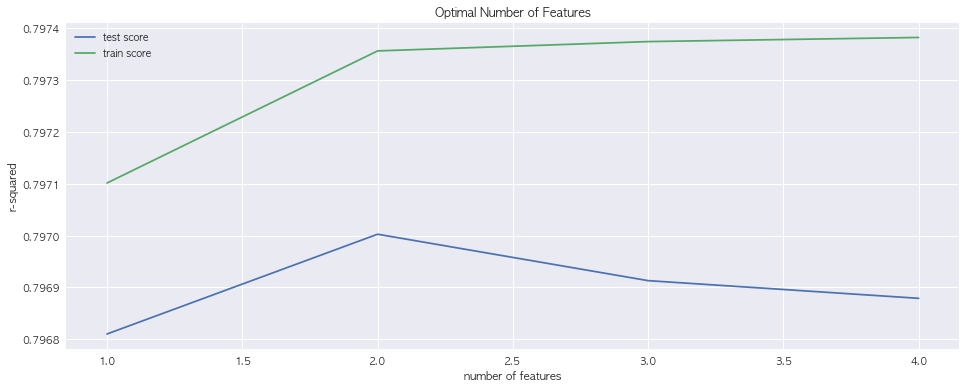

In [251]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [276]:
# final model
n_features_optimal = 2

lm = LinearRegression()
lm.fit(st_x_train, st_y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(st_x_train, st_y_train)

# predict prices of X_test
y_pred = lm.predict(st_x_test)
r2 = r2_score(st_y_test, y_pred)
print(r2)

0.8298675882771211


In [280]:
rfe.support_ # 'lgbm_pred0921-lgbm-optuna2.pickle', 'lgbm_pred0921-lgbm-bayes.pickle' 이거 두개 피쳐 썼다 

array([False,  True,  True, False])

In [286]:
print(rfe.estimator_.coef_)

[0.19340647 0.85209244]


In [284]:
rfe.estimator_.intercept_

380330.25944846496

### 최종 MAPE값~!! 

In [259]:
MAPE(y_pred, y_test)

27.229899476477197

## 3. 절편 없는 linear regression 

In [264]:
lr2 = LinearRegression(fit_intercept=False)

In [267]:
lr2.fit(st_x_train, st_y_train)
train_pred = lr2.predict(st_x_train)
lr2.score(st_x_train, st_y_train)

0.7972300191030821

In [268]:
print(lr2.coef_) # 추정된 회귀계수 (intercept제외)
print(lr2.intercept_) # intercept

[-0.07413385  0.20208985  0.88613801  0.04232593]
0.0


In [269]:
lr2.score(st_x_test, st_y_test)

0.8302997275858052

### 최종 MAPE

In [270]:
MAPE(lr2.predict(st_x_test), st_y_test)

27.64813210388767

In [271]:
lr2.predict(st_x_test)

array([11386964.30354303, 19376635.93532943, 24868287.1799361 , ...,
       35530574.34977954, 21611125.77318262, 12077774.06474131])

## 4. nnls 
* non-negative least square 
* 민정 앙상블 과제처럼, 모든 계수의 합이 positive가 되게끔 하는 방법 


* 공식 sklearn 패키지는 없고, 사용하려면 scipy.optimize.nnls 사용해야 하는데, 사용법이 굉장히 복잡해 보임.. 
* 따라서 이와 식이 상당히 유사한 `Lasso Regression(alpha=0, positive=True)` 를 써 보겠음! 

In [289]:
from sklearn.linear_model import Lasso

In [290]:
reg_nnls = Lasso(alpha=0, positive=True)

In [291]:
reg_nnls.fit(st_x_train, st_y_train)
train_pred = reg_nnls.predict(st_x_train)
reg_nnls.score(st_x_train, st_y_train)

0.7973562783988606

In [294]:
print(reg_nnls.coef_, reg_nnls.intercept_)

[0.         0.20263435 0.84282134 0.        ] 380487.9724007845


In [295]:
reg_nnls.score(st_x_test, st_y_test)

0.8298060404393788

### 최종 MAPE

In [297]:
MAPE(reg_nnls.predict(st_x_test), st_y_test)

27.23067808971849

### without intercept

In [298]:
reg_nnls2 = Lasso(alpha=0, positive=True, fit_intercept=False)

In [299]:
reg_nnls2.fit(st_x_train, st_y_train)
train_pred = reg_nnls2.predict(st_x_train)
reg_nnls2.score(st_x_train, st_y_train)

0.797008582634255

In [300]:
print(reg_nnls2.coef_, reg_nnls2.intercept_)

[0.15235208 0.27626181 0.62727962 0.        ] 0.0


In [302]:
reg_nnls2.score(st_x_test, st_y_test)

0.8298397493065919

### 최종 MAPE

In [303]:
MAPE(reg_nnls2.predict(st_x_test), st_y_test)

27.671995790122818